<a href="https://colab.research.google.com/github/trankha1655/CS114_ML/blob/main/%C4%90%E1%BB%93%20%C3%A1n%20cu%E1%BB%91i%20k%E1%BB%B3/Colab_train/Enet_midcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Aug  6 04:39:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# clone data

In [ ]:
!pip install labelme

In [ ]:
!apt install subversion

In [ ]:
!svn checkout https://github.com/trankha1655/CS114_ML/trunk/Đồ%20án%20cuối%20kỳ/Dataset/img
!svn checkout https://github.com/trankha1655/CS114_ML/trunk/Đồ%20án%20cuối%20kỳ/Dataset/json
!svn checkout https://github.com/trankha1655/CS114_ML/trunk/Đồ%20án%20cuối%20kỳ/Dataset/csv

# Lib

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import cv2
import os
from tqdm import tqdm
from PIL import Image
import albumentations as A
import labelme 
import random
import pandas as pd
import json
from labelme.utils import shape

In [ ]:
!nvidia-smi

Fri Aug  6 04:43:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Build Model

#### InitialBlock

In [ ]:
class InitialBlock(nn.Module):
  
  # Initial block of the model:
  #         Input
  #        /     \
  #       /       \
  #maxpool2d    conv2d-3x3
  #       \       /  
  #        \     /
  #      concatenate
   
    def __init__ (self,in_channels = 3,out_channels = 13):
        super().__init__()


        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                      stride = 2, 
                                      padding = 0)

        self.conv = nn.Conv2d(in_channels, 
                                out_channels,
                                kernel_size = 3,
                                stride = 2, 
                                padding = 1)

        self.prelu = nn.PReLU(16)

        self.batchnorm = nn.BatchNorm2d(out_channels)
  
    def forward(self, x):
        
        main = self.conv(x)
        main = self.batchnorm(main)
        
        side = self.maxpool(x)
        
        # concatenating on the channels axis
        x = torch.cat((main, side), dim=1)
        x = self.prelu(x)
        
        return x

#### UBNeck

In [ ]:
class UBNeck(nn.Module):
    
  # Upsampling bottleneck:
  #     Bottleneck Input
  #        /        \
  #       /          \
  # conv2d-1x1     convTrans2d-1x1
  #      |             | PReLU
  #      |         convTrans2d-3x3
  #      |             | PReLU
  #      |         convTrans2d-1x1
  #      |             |
  # maxunpool2d    Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  #  Params: 
  #  projection_ratio - ratio between input and output channels
  #  relu - if True: relu used as the activation function else: Prelu us used
  
    def __init__(self, in_channels, out_channels, relu=False, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.unpool = nn.MaxUnpool2d(kernel_size = 2,
                                     stride = 2)
        
        self.main_conv = nn.Conv2d(in_channels = self.in_channels,
                                    out_channels = self.out_channels,
                                    kernel_size = 1)
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        
        self.convt1 = nn.ConvTranspose2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               padding = 0,
                               bias = False)
        
        
        self.prelu1 = activation
        
        # This layer used for Upsampling
        self.convt2 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = 2,
                                  padding = 1,
                                  output_padding = 1,
                                  bias = False)
        
        self.prelu2 = activation
        
        self.convt3 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x, indices):
        x_copy = x
        
        # Side Branch
        x = self.convt1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.convt2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.convt3(x)
        x = self.batchnorm2(x)
        
        x = self.dropout(x)
        
        # Main Branch
        
        x_copy = self.main_conv(x_copy)
        x_copy = self.unpool(x_copy, indices, output_size=x.size())
        
        # summing the main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

#### RDDNeck

In [ ]:
class RDDNeck(nn.Module):
    def __init__(self, dilation, in_channels, out_channels, down_flag, relu=False, projection_ratio=4, p=0.1):
      
  # Regular|Dilated|Downsampling bottlenecks:
  #
  #     Bottleneck Input
  #        /        \
  #       /          \
  # maxpooling2d   conv2d-1x1
  #      |             | PReLU
  #      |         conv2d-3x3
  #      |             | PReLU
  #      |         conv2d-1x1
  #      |             |
  #  Padding2d     Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  # Params: 
  #  dilation (bool) - if True: creating dilation bottleneck
  #  down_flag (bool) - if True: creating downsampling bottleneck
  #  projection_ratio - ratio between input and output channels
  #  relu - if True: relu used as the activation function else: Prelu us used
  #  p - dropout ratio
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        
        self.out_channels = out_channels
        self.dilation = dilation
        self.down_flag = down_flag
        
        # calculating the number of reduced channels
        if down_flag:
            self.stride = 2
            self.reduced_depth = int(in_channels // projection_ratio)
        else:
            self.stride = 1
            self.reduced_depth = int(out_channels // projection_ratio)
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                      stride = 2,
                                      padding = 0, return_indices=True)
        

        
        self.dropout = nn.Dropout2d(p=p)

        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False,
                               dilation = 1)
        
        self.prelu1 = activation
        
        self.conv2 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = self.stride,
                                  padding = self.dilation,
                                  bias = True,
                                  dilation = self.dilation)
                                  
        self.prelu2 = activation
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False,
                                  dilation = 1)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
        
    def forward(self, x):
        
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        x = self.batchnorm2(x)
                
        x = self.dropout(x)
        
        # Main Branch
        if self.down_flag:
            x_copy, indices = self.maxpool(x_copy)
          
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            
            #padding and concatenating in order to match the channels axis of the side and main branches
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)

        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        if self.down_flag:
            return x, indices
        else:
            return x

#### ASNeck

In [ ]:
class ASNeck(nn.Module):
    def __init__(self, in_channels, out_channels, projection_ratio=4):
      
  # Asymetric bottleneck:
  #
  #     Bottleneck Input
  #        /        \
  #       /          \
  #      |         conv2d-1x1
  #      |             | PReLU
  #      |         conv2d-1x5
  #      |             |
  #      |         conv2d-5x1
  #      |             | PReLU
  #      |         conv2d-1x1
  #      |             |
  #  Padding2d     Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  # Params:    
  #  projection_ratio - ratio between input and output channels
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False)
        
        self.prelu1 = nn.PReLU()
        
        self.conv21 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (1, 5),
                                  stride = 1,
                                  padding = (0, 2),
                                  bias = False)
        
        self.conv22 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (5, 1),
                                  stride = 1,
                                  padding = (2, 0),
                                  bias = False)
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
                
        x = self.dropout(x)
        x = self.batchnorm2(x)
        
        # Main Branch
        
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            
            #padding and concatenating in order to match the channels axis of the side and main branches
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)
        
        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

#### ENet

In [ ]:
class ENet(nn.Module):
  
  # Creating Enet model!
  
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        # C - number of classes
        self.C = C
        
        # The initial block
        self.init = InitialBlock()
        
        
        # The first bottleneck
        self.b10 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=64, 
                           down_flag=True, 
                           p=0.01)
        
        self.b11 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b12 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b13 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b14 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        
        # The second bottleneck
        self.b20 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=128, 
                           down_flag=True)
        
        self.b21 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b22 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b23 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b24 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b25 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b26 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b27 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b28 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The third bottleneck
        self.b31 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b32 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b33 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b34 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b35 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b36 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b37 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b38 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The fourth bottleneck
        self.b40 = UBNeck(in_channels=128, 
                          out_channels=64, 
                          relu=True)
        
        self.b41 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.b42 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        
        # The fifth bottleneck
        self.b50 = UBNeck(in_channels=64, 
                          out_channels=16, 
                          relu=True)
        
        self.b51 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=16, 
                           down_flag=False, 
                           relu=True)
        
        
        # Final ConvTranspose Layer
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1,
                                           bias=False)
        
        
    def forward(self, x):
        
        # The initial block
        x = self.init(x)
        
        # The first bottleneck
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        
        # The second bottleneck
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        
        # The third bottleneck
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)
        
        # The fourth bottleneck
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        
        # The fifth bottleneck
        x = self.b50(x, i1)
        x = self.b51(x)
        
        # Final ConvTranspose Layer
        x = self.fullconv(x)
        
        return x

#### get model

In [ ]:
#enet = ENet(2)

In [ ]:
# Checking if there is any gpu available and pass the model to gpu or cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#enet = enet.to(device)

# Data genenrator

#### decoder

In [ ]:
def colormap2label():

    colormap2label = np.zeros(256**3)
    print(colormap2label.shape)
    for i, colormap in enumerate(COLORMAP):
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 +
                       colormap[2]] = i
    return colormap2label

def label_indices(colormap, colormap2label):

    colormap = colormap.astype(np.int32)
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 +
           colormap[:, :, 2])
    img = colormap2label[idx]
    return  img



COLORMAP = [[0, 0, 0], [255, 255, 255]]

CLASSES = ['background', 'road']

COLORMAP2LABEL = colormap2label()


(16777216,)


In [ ]:
def encoder_img(img):
    MEAN = 255 * torch.tensor([0.485, 0.456, 0.406])
    STD = 255 * torch.tensor([0.229, 0.224, 0.225])

    x = torch.from_numpy(np.array(img))
    x = x.type(torch.float32)
    x = x.permute(-1, 0, 1)
    x = (x - MEAN[:, None, None]) / STD[:, None, None]
    return x

#### get csv

In [ ]:
def div2(X,y,key=None):
    newX=[]
    newy=[]
    for i,j in zip(X,y):
        if i.split("/")[1] in key:
            newX.append(i)
            newy.append(j)
    return np.array(newX), np.array(newy)

In [ ]:
dir_cams = ['Kha_s cam']

In [ ]:


#_______ train
df = pd.read_csv("/content/csv/train_mask.csv")

temp =  list(  zip( df['path'].to_list() ,  df['label'].to_list() )   ) 
random.shuffle(    temp)     
a, b = zip(*temp )
X_train, y_train =  div2(a, b, dir_cams)


#______

df = pd.read_csv("/content/csv/val_mask.csv")

temp =  list(  zip( df['path'].to_list() ,  df['label'].to_list() )   ) 
random.shuffle(    temp)     
a, b = zip(*temp)
X_val, y_val=  div2(a, b, dir_cams)

#_________



In [ ]:
print(len(X_train))
print(len(X_val))

print(len(y_train))
print(len(y_val))


361
72
361
72


In [ ]:
dir=["/content/img/","/content/json/"]

#### generator code

In [ ]:
def json2mask(json_path,h,w):

        data = json.load(open(json_path))
        

        #mask = Image.open(mask_path).convert('L') # Use mask.mode to know that the format of the read mask image is I, which is 32-bit integer data, so it must be converted to L format
        # Change to read directly from json file
        label_name_to_value = {"_background_": 0,"1":1,"2":2}
        mask, label_names = shape.shapes_to_label(img_shape=(720,1280), shapes=data['shapes'],label_name_to_value=label_name_to_value)
        
        obj_ids = np.unique(mask)  # Remove duplicate numbers in the array and sort
        obj_ids = obj_ids[1:]  # Remove the first index because it is the background
        masks = mask == obj_ids[:, None, None]  # split the color-encoded mask into a set of binary masks

        #resize 
        mask= mask.astype("float32")
        resize = A.Compose([
            A.Resize(width=w, height=h),
        ])
        mask= resize(image=mask)["image"]
        mask= 255*mask

        #convert to 0-1
        #ret, thresh1 = cv2.threshold(clone, 120, 255, cv2.THRESH_BINARY)
        mask= np.where(mask > 120, 255, 0)
        mask= mask/255
        mask= mask.astype("int32")

        #return dim =2 [0,1] and [1,0]
        encoder= np.array([[0,0,0],[255,255,255]])
        out= encoder[mask]
        out =label_indices(out,COLORMAP2LABEL)
        #out= encoder[mask]

        #print(out)
        return out

In [ ]:
def loader(training_path, segmented_path, dir, batch_size, h=320, w=640):
    filenames_t = training_path
    total_files_t = len(filenames_t)
    
    filenames_s = segmented_path
    total_files_s = len(filenames_s)
    
    assert(total_files_t == total_files_s)
    
    if str(batch_size).lower() == 'all':
        batch_size = total_files_s
    
    idx = 0

    resize = A.Compose([
            A.Resize(width=w, height=h),
        ])

    while(1):
      # Choosing random indexes of images and labels
        batch_idxs = np.random.randint(0, total_files_s, batch_size)
            
        
        inputs = []
        labels = []
        
        for jj in batch_idxs:
          # Reading normalized photo
            img = Image.open(dir[0] + filenames_t[jj])
            img = np.asarray(img)
          # Resizing using nearest neighbor method
            img = resize(image=img)["image"]
            #img = img[80:160, :, :]
            #img = cv2.resize(img, (h, w), cv2.INTER_NEAREST)
            inputs.append(img)

          # Reading semantic image
            mask = json2mask(dir[1] + filenames_s[jj],h,w)
        
                
            

          # Resizing using nearest neighbor method
            #img = img[80:160, :]
            #img = cv2.resize(img, (h, w), cv2.INTER_NEAREST)
            labels.append(mask)
         
        inputs = np.stack(inputs, axis=2)
      # Changing image format to C x H x W
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        
        labels = torch.tensor(labels)
        
        yield inputs, labels

#### weight

In [ ]:
def get_class_weights(num_classes, c=1.02):
    pipe = loader(X_train, y_train,dir, batch_size= 8)
    _, labels = next(pipe)
    #print(labels[1])
    all_labels = labels.flatten()
    each_class = np.bincount(all_labels, minlength=num_classes)
    prospensity_score = each_class / len(all_labels)
    class_weights = 1 / (np.log(c + prospensity_score))
    return class_weights

In [ ]:
class_weights = get_class_weights(2)

In [ ]:
print(class_weights)

[1.54324297 8.28338545]


# compile model

#### compile

In [ ]:
#PyTorch
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU


In [ ]:
lr = 5e-4
batch_size = 32

criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
optimizer = torch.optim.Adam(enet.parameters(), 
                             lr=lr,
                             weight_decay=2e-4)

print_every = 1
eval_every = 2

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)  
print(count_parameters(enet))

351116


#### train evaluate

In [ ]:
torch.__version__

'1.9.0+cu102'

In [ ]:
train_losses = []
eval_losses = []
min_loss=10000

#!mkdir /content/drive/MyDrive/DataSimulateITCar/Enet2

bc_train = 1099  // batch_size # mini_batch train
bc_eval = 200 // batch_size  # mini_batch validation
print(bc_train)
print(bc_eval)

# Define pipeline objects
pipe = loader(X_train, y_train,dir, batch_size)
eval_pipe = loader(X_val, y_val,dir, batch_size)

epochs = 100
ex =100
# Train loop

for e in range(1, epochs+1):
    
    
    train_loss = 0
    print ('-'*15,'Epoch %d' % e, '-'*15)
    
    enet.train()
    
    for _ in tqdm(range(bc_train)):
        X_batch, mask_batch = next(pipe)
        
        # assign data to cpu/gpu
        X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)

        optimizer.zero_grad()

        out = enet(X_batch.float())
        
        # loss calculation
        loss = criterion(out, mask_batch.long())
        # update weights
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print ()    
        

    train_losses.append(train_loss)
    
    if (e+1) % print_every == 0:
        print ('Epoch {}/{}...'.format(e, epochs),
                'Loss {:6f}'.format(train_loss))
    
    if e % eval_every == 0:
        with torch.no_grad():
            enet.eval()
            
            eval_loss = 0

            # Validation loop
            for _ in tqdm(range(bc_eval)):
                inputs, labels = next(eval_pipe)

                
                inputs, labels = inputs.to(device), labels.to(device)
                    
                
                out = enet(inputs.float())
                
                out = out.data.max(1)[1]
                
                eval_loss += (labels.long() - out.long()).sum()
                
            
            print ()
            print ('Loss {:6f}'.format(eval_loss))
            
            eval_losses.append(eval_loss)
        
    if e % print_every == 0:
        if min_loss >train_loss:
            min_loss= train_loss
            checkpoint = {
                'epochs' : e,
                'state_dict' : enet.state_dict()
            }
            

            torch.save(checkpoint, '/content/drive/MyDrive/Model_/ckpt-enet2class_midcam-{}-{:2f}.pth'.format(e, train_loss))
            print ('Model saved!')
        else:
            print("Train loss did not improved from {}".format(min_loss))

print ('Epoch {}/{}...'.format(e, epochs),
       'Total Mean Loss: {:6f}'.format(sum(train_losses) / epochs))

  0%|          | 0/34 [00:00<?, ?it/s]

34
6
--------------- Epoch 1 ---------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 1/100... Loss 26.558526
Model saved!
--------------- Epoch 2 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 2/100... Loss 10.079222


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -17687086.000000
Model saved!
--------------- Epoch 3 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 3/100... Loss 5.945210
Model saved!
--------------- Epoch 4 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 4/100... Loss 4.058594


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -10886138.000000
Model saved!
--------------- Epoch 5 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 5/100... Loss 3.242621
Model saved!
--------------- Epoch 6 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 6/100... Loss 2.590339


100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -2823388.000000
Model saved!
--------------- Epoch 7 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 7/100... Loss 2.126778
Model saved!
--------------- Epoch 8 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 8/100... Loss 1.960419


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -1351300.000000
Model saved!
--------------- Epoch 9 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 9/100... Loss 1.848978
Model saved!
--------------- Epoch 10 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 10/100... Loss 1.700776


100%|██████████| 6/6 [00:13<00:00,  2.18s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -553045.000000
Model saved!
--------------- Epoch 11 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 11/100... Loss 1.508885
Model saved!
--------------- Epoch 12 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 12/100... Loss 1.550221


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -256661.000000
Train loss did not improved from 1.508885432034731
--------------- Epoch 13 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 13/100... Loss 1.459713
Model saved!
--------------- Epoch 14 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 14/100... Loss 1.384679


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 449475.000000
Model saved!
--------------- Epoch 15 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 15/100... Loss 1.295336
Model saved!
--------------- Epoch 16 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 16/100... Loss 1.236673


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 1521223.000000
Model saved!
--------------- Epoch 17 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 17/100... Loss 1.207253
Model saved!
--------------- Epoch 18 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 18/100... Loss 1.204551


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -251353.000000
Model saved!
--------------- Epoch 19 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 19/100... Loss 1.292998
Train loss did not improved from 1.2045507058501244
--------------- Epoch 20 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 20/100... Loss 1.125378


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 1210488.000000
Model saved!
--------------- Epoch 21 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 21/100... Loss 1.081759
Model saved!
--------------- Epoch 22 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 22/100... Loss 1.027328


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 2848565.000000
Model saved!
--------------- Epoch 23 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 23/100... Loss 0.997564
Model saved!
--------------- Epoch 24 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 24/100... Loss 0.980829


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 3112995.000000
Model saved!
--------------- Epoch 25 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 25/100... Loss 0.966261
Model saved!
--------------- Epoch 26 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 26/100... Loss 0.975483


100%|██████████| 6/6 [00:13<00:00,  2.18s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 3613431.000000
Train loss did not improved from 0.9662614222615957
--------------- Epoch 27 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 27/100... Loss 1.023765
Train loss did not improved from 0.9662614222615957
--------------- Epoch 28 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 28/100... Loss 0.958731


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 3804587.000000
Model saved!
--------------- Epoch 29 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 29/100... Loss 0.909430
Model saved!
--------------- Epoch 30 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 30/100... Loss 0.866250


100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 3943099.000000
Model saved!
--------------- Epoch 31 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 31/100... Loss 0.833680
Model saved!
--------------- Epoch 32 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 32/100... Loss 0.824185


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 3209561.000000
Model saved!
--------------- Epoch 33 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 33/100... Loss 0.864687
Train loss did not improved from 0.8241846729069948
--------------- Epoch 34 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 34/100... Loss 0.802687


100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 2857117.000000
Model saved!
--------------- Epoch 35 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 35/100... Loss 0.755661
Model saved!
--------------- Epoch 36 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 36/100... Loss 0.751524


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 875047.000000
Model saved!
--------------- Epoch 37 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 37/100... Loss 0.760464
Train loss did not improved from 0.7515240535140038
--------------- Epoch 38 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 38/100... Loss 0.760219


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 1766975.000000
Train loss did not improved from 0.7515240535140038
--------------- Epoch 39 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 39/100... Loss 1.066806
Train loss did not improved from 0.7515240535140038
--------------- Epoch 40 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 40/100... Loss 0.967217


100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -5818432.000000
Train loss did not improved from 0.7515240535140038
--------------- Epoch 41 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 41/100... Loss 0.838944
Train loss did not improved from 0.7515240535140038
--------------- Epoch 42 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 42/100... Loss 0.770033


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 53244.000000
Train loss did not improved from 0.7515240535140038
--------------- Epoch 43 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 43/100... Loss 0.757898
Train loss did not improved from 0.7515240535140038
--------------- Epoch 44 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 44/100... Loss 0.722197


100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -3977236.000000
Model saved!
--------------- Epoch 45 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 45/100... Loss 0.726686
Train loss did not improved from 0.7221970241516829
--------------- Epoch 46 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 46/100... Loss 0.722959


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -5150207.000000
Train loss did not improved from 0.7221970241516829
--------------- Epoch 47 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 47/100... Loss 0.681878
Model saved!
--------------- Epoch 48 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 48/100... Loss 0.655759


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -5706997.000000
Model saved!
--------------- Epoch 49 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 49/100... Loss 0.655703
Model saved!
--------------- Epoch 50 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 50/100... Loss 0.688303


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -17773446.000000
Train loss did not improved from 0.6557026281952858
--------------- Epoch 51 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 51/100... Loss 0.627430
Model saved!
--------------- Epoch 52 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 52/100... Loss 0.628737


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -11968220.000000
Train loss did not improved from 0.6274299081414938
--------------- Epoch 53 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 53/100... Loss 0.650525
Train loss did not improved from 0.6274299081414938
--------------- Epoch 54 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 54/100... Loss 0.621479


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -15558523.000000
Model saved!
--------------- Epoch 55 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 55/100... Loss 0.618407
Model saved!
--------------- Epoch 56 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 56/100... Loss 0.625629


100%|██████████| 6/6 [00:12<00:00,  2.17s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -18717751.000000
Train loss did not improved from 0.6184072345495224
--------------- Epoch 57 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 57/100... Loss 0.623815
Train loss did not improved from 0.6184072345495224
--------------- Epoch 58 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 58/100... Loss 0.590865


100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -22276319.000000
Model saved!
--------------- Epoch 59 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 59/100... Loss 0.570253
Model saved!
--------------- Epoch 60 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 60/100... Loss 0.550284


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -29217681.000000
Model saved!
--------------- Epoch 61 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 61/100... Loss 0.555771
Train loss did not improved from 0.5502841966226697
--------------- Epoch 62 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 62/100... Loss 0.586127


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -18413609.000000
Train loss did not improved from 0.5502841966226697
--------------- Epoch 63 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 63/100... Loss 0.571688
Train loss did not improved from 0.5502841966226697
--------------- Epoch 64 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 64/100... Loss 0.587775


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -22384230.000000
Train loss did not improved from 0.5502841966226697
--------------- Epoch 65 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 65/100... Loss 0.601444
Train loss did not improved from 0.5502841966226697
--------------- Epoch 66 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 66/100... Loss 1.034501


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -18236002.000000
Train loss did not improved from 0.5502841966226697
--------------- Epoch 67 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 67/100... Loss 1.145923
Train loss did not improved from 0.5502841966226697
--------------- Epoch 68 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 68/100... Loss 0.824313


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -26644260.000000
Train loss did not improved from 0.5502841966226697
--------------- Epoch 69 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 69/100... Loss 0.724922
Train loss did not improved from 0.5502841966226697
--------------- Epoch 70 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 70/100... Loss 0.667579


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -33397971.000000
Train loss did not improved from 0.5502841966226697
--------------- Epoch 71 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 71/100... Loss 0.624778
Train loss did not improved from 0.5502841966226697
--------------- Epoch 72 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 72/100... Loss 0.577806


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34213713.000000
Train loss did not improved from 0.5502841966226697
--------------- Epoch 73 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 73/100... Loss 0.569910
Train loss did not improved from 0.5502841966226697
--------------- Epoch 74 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 74/100... Loss 0.621515


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -33998180.000000
Train loss did not improved from 0.5502841966226697
--------------- Epoch 75 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 75/100... Loss 0.706858
Train loss did not improved from 0.5502841966226697
--------------- Epoch 76 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 76/100... Loss 0.598895


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34495777.000000
Train loss did not improved from 0.5502841966226697
--------------- Epoch 77 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 77/100... Loss 0.547425
Model saved!
--------------- Epoch 78 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 78/100... Loss 0.520836


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34523723.000000
Model saved!
--------------- Epoch 79 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 79/100... Loss 0.511921
Model saved!
--------------- Epoch 80 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 80/100... Loss 0.528090


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34588152.000000
Train loss did not improved from 0.5119207808747888
--------------- Epoch 81 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 81/100... Loss 0.552541
Train loss did not improved from 0.5119207808747888
--------------- Epoch 82 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 82/100... Loss 0.536851


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34554645.000000
Train loss did not improved from 0.5119207808747888
--------------- Epoch 83 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 83/100... Loss 0.555994
Train loss did not improved from 0.5119207808747888
--------------- Epoch 84 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 84/100... Loss 0.521775


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34473312.000000
Train loss did not improved from 0.5119207808747888
--------------- Epoch 85 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 85/100... Loss 0.503668
Model saved!
--------------- Epoch 86 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 86/100... Loss 0.522204


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34611557.000000
Train loss did not improved from 0.503667545504868
--------------- Epoch 87 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 87/100... Loss 0.604617
Train loss did not improved from 0.503667545504868
--------------- Epoch 88 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 88/100... Loss 1.006206


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34770472.000000
Train loss did not improved from 0.503667545504868
--------------- Epoch 89 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 89/100... Loss 0.770550
Train loss did not improved from 0.503667545504868
--------------- Epoch 90 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 90/100... Loss 0.693575


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34582256.000000
Train loss did not improved from 0.503667545504868
--------------- Epoch 91 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 91/100... Loss 0.646810
Train loss did not improved from 0.503667545504868
--------------- Epoch 92 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 92/100... Loss 0.564700


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34631094.000000
Train loss did not improved from 0.503667545504868
--------------- Epoch 93 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 93/100... Loss 0.531201
Train loss did not improved from 0.503667545504868
--------------- Epoch 94 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 94/100... Loss 0.538062


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34656591.000000
Train loss did not improved from 0.503667545504868
--------------- Epoch 95 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 95/100... Loss 0.629656
Train loss did not improved from 0.503667545504868
--------------- Epoch 96 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 96/100... Loss 0.576818


100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34629375.000000
Train loss did not improved from 0.503667545504868
--------------- Epoch 97 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 97/100... Loss 0.519601
Train loss did not improved from 0.503667545504868
--------------- Epoch 98 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 98/100... Loss 0.506426


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34683124.000000
Train loss did not improved from 0.503667545504868
--------------- Epoch 99 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 99/100... Loss 0.492667
Model saved!
--------------- Epoch 100 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 100/100... Loss 0.472528


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]



Loss -34628220.000000
Model saved!
Epoch 100/100... Total Mean Loss: 1.297340


In [ ]:
#train_losses = []
#eval_losses = []
#min_loss=10000

#!mkdir /content/drive/MyDrive/DataSimulateITCar/Enet2

#bc_train = 1099  // batch_size # mini_batch train
#bc_eval = 200 // batch_size  # mini_batch validation
#print(bc_train)
#print(bc_eval)

# Define pipeline objects
#pipe = loader(X_train, y_train,dir, batch_size)
#eval_pipe = loader(X_val, y_val,dir, batch_size)

epochs = 100
ex =100
# Train loop

for e in range(1+ex,ex+ epochs+1):
    
    
    train_loss = 0
    print ('-'*15,'Epoch %d' % e, '-'*15)
    
    enet.train()
    
    for _ in tqdm(range(bc_train)):
        X_batch, mask_batch = next(pipe)
        
        # assign data to cpu/gpu
        X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)

        optimizer.zero_grad()

        out = enet(X_batch.float())
        
        # loss calculation
        loss = criterion(out, mask_batch.long())
        # update weights
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print ()    
        

    train_losses.append(train_loss)
    
    if (e+1) % print_every == 0:
        print ('Epoch {}/{}...'.format(e, epochs),
                'Loss {:6f}'.format(train_loss))
    
    if e % eval_every == 0:
        with torch.no_grad():
            enet.eval()
            
            eval_loss = 0

            # Validation loop
            for _ in tqdm(range(bc_eval)):
                inputs, labels = next(eval_pipe)

                
                inputs, labels = inputs.to(device), labels.to(device)
                    
                
                out = enet(inputs.float())
                
                out = out.data.max(1)[1]
                
                eval_loss += (labels.long() - out.long()).sum()
                
            
            print ()
            print ('Loss {:6f}'.format(eval_loss))
            
            eval_losses.append(eval_loss)
        
    if e % print_every == 0:
        if min_loss >train_loss:
            min_loss= train_loss
            checkpoint = {
                'epochs' : e,
                'state_dict' : enet.state_dict()
            }
            

            torch.save(checkpoint, '/content/drive/MyDrive/Model_/ckpt-enet2class_midcam-{}-{:2f}.pth'.format(e, train_loss))
            print ('Model saved!')
        else:
            print("Train loss did not improved from {}".format(min_loss))

print ('Epoch {}/{}...'.format(e, epochs),
       'Total Mean Loss: {:6f}'.format(sum(train_losses) / epochs))

  0%|          | 0/34 [00:00<?, ?it/s]

--------------- Epoch 101 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 101/100... Loss 0.471429
Model saved!
--------------- Epoch 102 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 102/100... Loss 0.463667


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34756959.000000
Model saved!
--------------- Epoch 103 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 103/100... Loss 0.475501
Train loss did not improved from 0.4636671459302306
--------------- Epoch 104 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 104/100... Loss 0.493863


100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34766610.000000
Train loss did not improved from 0.4636671459302306
--------------- Epoch 105 ---------------


  0%|          | 0/34 [00:00<?, ?it/s]


Epoch 105/100... Loss 0.488805
Train loss did not improved from 0.4636671459302306
--------------- Epoch 106 ---------------


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 106/100... Loss 0.649965


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


  0%|          | 0/34 [00:00<?, ?it/s]

Loss -34835765.000000
Train loss did not improved from 0.4636671459302306
--------------- Epoch 107 ---------------


#load, predict, plot

In [ ]:
#load Model
enet = ENet(2)
device= "cuda"
state_dict = torch.load('/content/drive/MyDrive/Model_/ckpt-enet2class_midcam-99-0.492667.pth',  map_location= torch.device('cuda'))['state_dict']
enet.load_state_dict(state_dict)
#enet.eval()


<All keys matched successfully>

In [ ]:
#get 1 batch from val_train
eval_pipe = loader(X_val, y_val,dir, 16)
X_batch, mask_batch = next(eval_pipe)
X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)


In [ ]:
#predict
import time 
enet.to(device)

with torch.no_grad():
    nw= time.time()
    out1 = enet(X_batch.float())
    print("execute in: ", time.time()-nw)
print(out1.shape)


b_ = out1.data.max(1)[1].cpu().numpy()

execute in:  0.06223726272583008
torch.Size([16, 2, 320, 640])


In [ ]:
#create data to plot
batch=[]
for i in range(8):
    batch.append(    [np.array(X_batch.transpose(1,2).transpose(2,3).data[i].cpu()) ,  np.array(b_[i])  ,  np.array( mask_batch.data[i].cpu())   ]  )

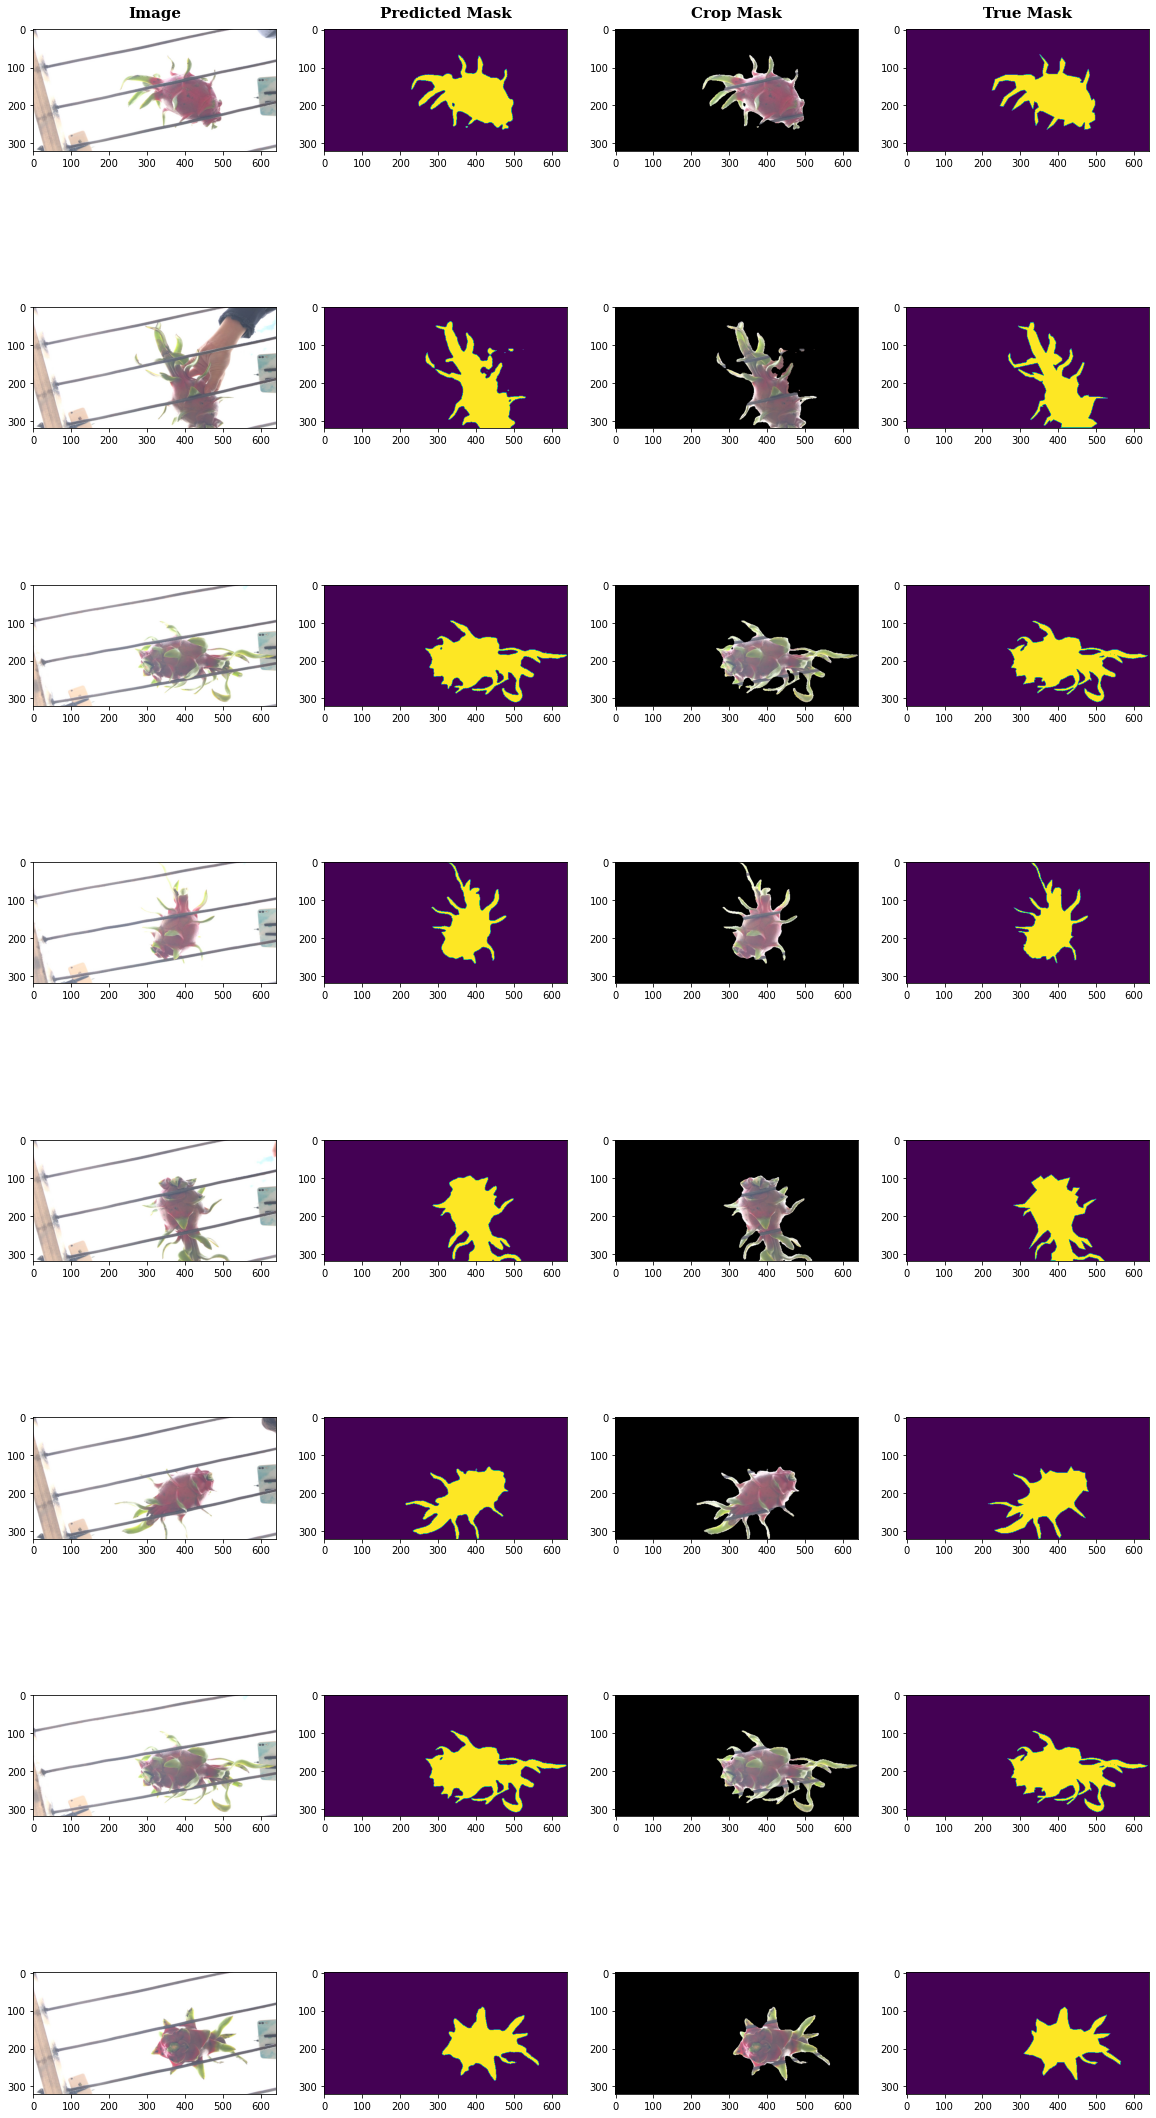

In [ ]:
#main code to plot

fig, axes = plt.subplots(len(batch), 4, figsize=(4*5, len(batch) * 5))

for i in range(len(batch)):
    
         
    
    image = batch[i][0]

    binary_predicted_mask  =  batch[i][1] 

    true_mask =  batch[i][2]

    #image=  loader_min(image=image)["image"]
    #predicted_mask = loader_min(image=predicted_mask)["image"]
    #true_mask = loader_min(image=true_mask)["image"]

    
    fg= binary_predicted_mask.copy().astype(np.int8)
    


    fg = cv2.bitwise_or(image, image, mask=fg)
    
    image_ax, predicted_mask_ax ,fg_ax ,t_mask_ax = axes[i, 0], axes[i, 1], axes[i, 2] ,axes[i,3]
    
    image_ax.imshow(image)
    
    predicted_mask_ax.imshow(binary_predicted_mask)

    t_mask_ax.imshow(true_mask)

    fg_ax.imshow(fg)
    
    
    if i == 0:
        image_ax.set_title("Image", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)
        
        predicted_mask_ax.set_title("Predicted Mask", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)
        fg_ax.set_title("Crop Mask", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)

        t_mask_ax.set_title("True Mask", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)
        
fig.savefig("Plot_Unet.png")
fig.show()

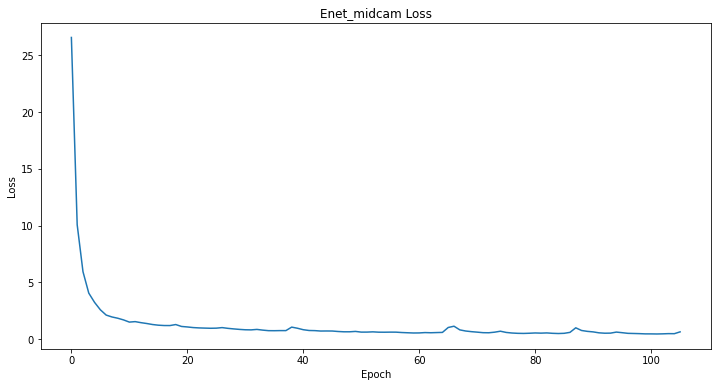

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,6))
plt.title("Enet_midcam Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss)